[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/adams/blob/master/exercises/Ex07_manual_RNN/Ex07-manual-RNN.ipynb) 

In [1]:
# Setting up the environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import expit as sigmoid

# Make Jupyter output multiple results without explicit print statements (see https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Recurrent Neural Networks

We are now entering a whole different realm. Data is no longer frozen in time, no longer IID -  the temporal fluctuations of our variables are now in the center of attention. Additionally, we can no longer fool around shuffling and sampling our data, as the time order matters - it will be reflecting the actual flow of change. This is a substantial change to how we think about a modeling task. Those of you who dealt with panel data and time series might already be familiar with approaches to handle sequential data. Either way, revisiting  autoregressive models might be a good idea. 
Fortunately, dealing with time series data requires no fundamental change to the training algorithms we've learned until now. Building on top of what we know, we will see how we can improve our model architectures to fit some specific issues. 

We will be focusing on the task of figuring out  $p(x_{t}|x_{t−1},…x_{1}) $, where $t$ specifies the order of observations. The order could be implied by time (what is the value of x in the future, given the past values of x) or syntax (what's the next word in a sentence starting with words x,y and z).

Today we will see how RNNs accommodate this task.

**Outline**
1. Sequential data
2. Recurrent cells and networks
3. Long short-term memory

## 1. Sequential data
We discuss some of the peculiarities of sequential data and how to address them during data preparation. Our use case will be stock market data. 

### Load the data
Financial data (at a daily level) is publicly available online. The data for this tutorial was downloaded from [Yahoo finance](https://finance.yahoo.com/quote/AMZN/history?p=AMZN) but many other sources exist. You can download the data yourself to benefit from the most recent set of data or simply use the data set from Moodle. Clearly, you can also change the subject of analysis. We look at Amazon stock prices but any other stock - or time series - will do.

In [12]:
data = pd.read_csv('../../data/AMZN.csv')
data.set_index('Date', inplace=True)  # This is the first time we deal with time series data. Using the date as index is useful for subsetting
data.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-24,1951.500000,1955.000000,1900.339966,1940.099976,1940.099976,7147100
2020-03-25,1920.689941,1950.260010,1885.780029,1885.839966,1885.839966,6479100
2020-03-26,1902.000000,1956.489990,1889.290039,1955.489990,1955.489990,6221300
2020-03-27,1930.859985,1939.790039,1899.920044,1900.099976,1900.099976,5387900
2020-03-30,1922.829956,1973.630005,1912.339966,1963.949951,1963.949951,6115100


In [13]:
# We only need the adjusted closing price
data.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
data.columns = ['Price']
data.tail()

,Price
Date,
2020-03-24,1940.099976
2020-03-25,1885.839966
2020-03-26,1955.489990
2020-03-27,1900.099976
2020-03-30,1963.949951


In [6]:
data.shape

(2769, 1)

In [7]:
data.index.values

array(['2009-03-31', '2009-04-01', '2009-04-02', ..., '2020-03-26',
       '2020-03-27', '2020-03-30'], dtype=object)

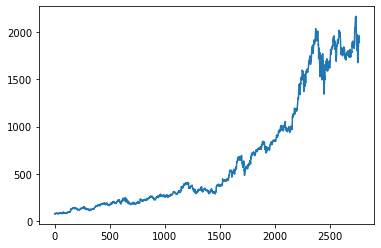

In [10]:
plt.plot(data["Price"].values)
plt.show();

### Preparing sequential data
Let's try to see what RNN can do with some financial data. We take the stock price of Amazon for the past 2 years from Yahoo Finance. 
We will ignore other available information, like the stock price of other e-commerce companies or tax rates in Ireland. Our data is thus a single variable, the stock price. While we move through time, we predict the price in the next period based on the previous periods' prices. We then move one period ahead and the actual price of last period becomes a new observation. 

$$ 
\widehat{price_t} = f(price_{t-1},price_{t-2},price_{t-3},price_{t-4},\ldots) 
$$

<img src="time_series_structure.png" style="width: 800px;"/>

Source: https://humboldt-wi.github.io/blog/research/information_systems_1819/02lstmgruandbeyond/

We can see a clear trend in the data of the share price increasing over time. That's easy for our model to pick up and not very informative, so we better standardize the mean price over time. Instead of the overall price, we will predict the price difference from today to tomorrow's closing price. 
Pandas knows a the function *.shift()*. Have a look at its documentation. This function is what we need to calculate price differences.

In [14]:
data["Price"] = (data["Price"] - data["Price"].shift(1))

In [15]:
# The previous shift causes the first entry in our dataframe to be NaN
data.head(3)

,Price
Date,
2009-03-31,NaN
2009-04-01,0.059998
2009-04-02,2.839996


In [16]:
# Make sure you understand where the NaN value is coming from
# To get rid of it, we discard the first entry
print('Original dimension: ' + 'x'.join(map(str,data.shape)))
data = data.iloc[1:,:]
print('New dimension: ' + 'x'.join(map(str,data.shape)))

Original dimension: 2769x1
New dimension: 2768x1


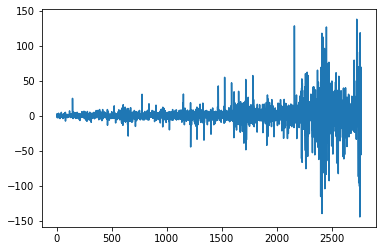

In [19]:
# Plot series of price differences (i.e., returns)
plt.plot(data.Price.values)
plt.show();

There is more preprocessing we could/should do. We'll refer to one of the excellent classes on time-series forecasting at the faculty instead. 

To evaluate the model and potential overfitting, we want a train/test split. 
Remember that our observations have a time structure now - no shuffling, strictly use observations from the future for testing! With that in mind, there really is no need to involve scikit-learn for data organization.

In [21]:
train_size  = int(len(data) * 0.80)
test_size   = len(data) - train_size
train, test = data[:train_size], data[train_size:]

We will apply the usual preprocessing to standardize the input data. 

In [22]:
#Data preparation (can be skipped)

# Convert data to numpy array.
# The conversion will alter the dimension. We redo this with the rescaling 
train = train["Price"].to_numpy().reshape([-1,1]) # note that the -1 means that the dimension of the axis will be inferred from the data
test = test["Price"].to_numpy().reshape([-1,1]) # in plain English, it is equivalent to inputting the number of rows (i.e., train_size) as argument
from sklearn.preprocessing import MinMaxScaler
#Standardize the values to a range from zero to 1
#Note the proper application of the scaler: fitting parameters on train and apply these to test
scaler = MinMaxScaler()
train  = scaler.fit_transform(train)
test   = scaler.transform(test)

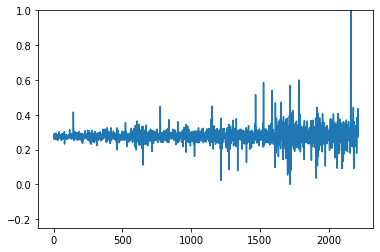

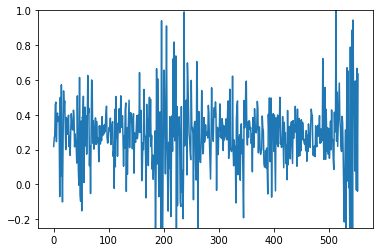

In [24]:
plt.ylim([-0.25,1])
plt.plot(train)
plt.show()  ;

plt.ylim([-0.25,1])
plt.plot(test)
plt.show();

In [26]:
train

array([[0.27370381],
       [0.28942156],
       [0.28371118],
       ...,
       [0.39972918],
       [0.43461244],
       [0.27144246]])

The data is almost ready for developing a forecasting model. What is missing? 
Remeber we are tryting to build an autoregressive model, which uses past realizations of the target variable as input.
So the following bits help us create the input data structure for such a model.

In [27]:
def create_dataset(time_series, window_size):
    """ Function to create data set with lagged response values for estimating an autoregressive model"""
    dataX, dataY = [], []
    
    for i in range(0,len(time_series) - window_size - 1):
        x = time_series[i:i + window_size] # Remember: x[a:b-1]
        dataX.append(x)
        y = time_series[i + window_size] # Remember: x[b]
        dataY.append(y)
           
    return np.array(dataX), np.array(dataY)

In [33]:
WINDOW_SIZE=22

X_train, y_train  = create_dataset(train, WINDOW_SIZE)
X_test, y_test   = create_dataset(test, WINDOW_SIZE)
print (X_train.shape)
print (y_train.shape)

(2191, 22, 1)
(2191, 1)


Again, note how feature values are shifted by one period between one observation and the next observation. 

In [29]:
X_train[0:2,:,0]

array([[0.27370381, 0.28942156, 0.28371118, 0.27234689, 0.259343  ,
        0.28167578, 0.28913885, 0.2686719 , 0.26363992, 0.25917335,
        0.28772543, 0.2778877 , 0.27065071, 0.2799796 , 0.27596536,
        0.28133657, 0.29513198, 0.26578842, 0.26929379, 0.25860797,
        0.27749189, 0.26454456],
       [0.28942156, 0.28371118, 0.27234689, 0.259343  , 0.28167578,
        0.28913885, 0.2686719 , 0.26363992, 0.25917335, 0.28772543,
        0.2778877 , 0.27065071, 0.2799796 , 0.27596536, 0.28133657,
        0.29513198, 0.26578842, 0.26929379, 0.25860797, 0.27749189,
        0.26454456, 0.27794421]])

In [143]:
y_train

array([[0.45582384],
       [0.42542926],
       [0.45412469],
       ...,
       [0.58174326],
       [0.46507475],
       [0.57844089]])

Let us verify the sequential pattern in our data. To that end, we first append our target variable as a new column (after performing some reshaping to make that operation possible) and output a couple of values. 

In [25]:
# Append the target variable to our array as a new column
np.hstack([X_train, y_train.reshape([-1,1,1])])[0:10,:,0]

array([[0.43156475, 0.44043772, 0.41032639, 0.4848025 , 0.45072661,
        0.48225385, 0.4408153 , 0.48933333, 0.44468545, 0.4354349 ,
        0.48536884, 0.47951644, 0.39984875, 0.44921635, 0.42646752,
        0.44761169, 0.50641844, 0.4546911 , 0.46394164, 0.48480242,
        0.45695659, 0.44685644, 0.45582384],
       [0.44043772, 0.41032639, 0.4848025 , 0.45072661, 0.48225385,
        0.4408153 , 0.48933333, 0.44468545, 0.4354349 , 0.48536884,
        0.47951644, 0.39984875, 0.44921635, 0.42646752, 0.44761169,
        0.50641844, 0.4546911 , 0.46394164, 0.48480242, 0.45695659,
        0.44685644, 0.45582384, 0.42542926],
       [0.41032639, 0.4848025 , 0.45072661, 0.48225385, 0.4408153 ,
        0.48933333, 0.44468545, 0.4354349 , 0.48536884, 0.47951644,
        0.39984875, 0.44921635, 0.42646752, 0.44761169, 0.50641844,
        0.4546911 , 0.46394164, 0.48480242, 0.45695659, 0.44685644,
        0.45582384, 0.42542926, 0.45412469],
       [0.4848025 , 0.45072661, 0.48225385, 0.440

Since we have only one variable, the price of the Amazon stock, our data fits into a 2D array. The column dimension of such an array stores the different lags of our (single) variable. 
The row dimension represents different observations or points in time. Here is an example:

|t | $x_{t-1}$ |$x_{t-2}$ | $\ldots$ |
|---|---|---|---|
|1        | 900 | 899| $\ldots$|
|2        | 905|900 | $\ldots$|
|$\ldots$ | $\ldots$| $\ldots$ | $\ldots$|



If we had additional variables, each with a time stamp of its own, we would need a 2D table for each variable or put them into a 3D array [observations, time periods, features]. This is what tensorflow expects, so we'll reshape our 2D data to conform with the more general 3D case.

In [35]:
#Reshape input to be [samples, time steps, features]
X_train  = np.reshape(X_train, (X_train.shape[0],X_train.shape[1], 1))
X_test   = np.reshape(X_test, (X_test.shape[0],X_test.shape[1], 1))

print(X_train.shape, y_train.shape,X_test.shape, y_test.shape)
#Train set ended up with 1789 samples, 22 obs each and 1 feature

(2191, 22, 1) (2191, 1) (531, 22, 1) (531, 1)


The value 22, which was our _window size_ is probably the part most difficult to grasp. In a nutshell, we feed our RNN with subsets or slices of our time series. The window size determines the size of one such slice. We then interpret one slice as one observation, which resembles the non-recurrent, feedforward neural networks we considered before. There, one observation was something like one client or borrower, who was characterized by $m$ feature values. RNNs extend that idea. For each feature, we have a time series of which we feed the network slices. Let's examine this in more detail.

## Recurrent cells and networks

A Recurrent Neural Network processes input variables at each time step and carries a representation of the current state forward.

<img src="RNN_rollout_single.png" />

<img src="RNN_rollout_series.gif" />

Source: https://towardsdatascience.com/illustrated-guide-to-recurrent-neural-networks-79e5eb8049c9

### RNN architecture
<img src="RNN_update.png" style="width: 500px;"/>

Source: https://humboldt-wi.github.io/blog/research/information_systems_1819/02lstmgruandbeyond/

Remark: please ignore the use of the ReLu function in the output layer, which the picture suggests. The picture is taken from our blog where a RNN was used to predict a strictly positve quantity. In general, the output layer activation function depends on your modeling task. For example, we would use _softmax_ when facing a multi-class classification problem.

Let's assume we are able to remember one period back. When we woke up yesterday, we had available the price in period t-1. We processed the input available at that time $x_{t-1}$ and formed some impression of what is going on with the stock. We call this impression the hidden state, because it is not data that we have observed, but information that we keep in our mind. 

Today, we observe another price input $x_{t}$. We process this input and put it together with the impression that we had formed yesterday. We combine the old impression and new input to form a new impression of what is happening on the stock market at period t. 

We can make use of this impression, whenever someone asks us for a prediction of what is going to happen tomorrow $x_{t+1}$.

We can express this model using three matrices: 1. an input matrix to process new information, 2. a hidden matrix to form a new impression given the previous impression and the processed new input, and 3. the output matrix to make a prediction from our current impression.
$$ \textrm{processed input} = W_{in} \vec{x_{t}}+\vec{b_{in}} $$

$$\vec{h_t} = tanh \left( W_{h} \vec{h_{t-1}}  + \textrm{processed input} + \vec{b_{h}} \right)$$

$$\vec{y_{t+1}} = I(W_{out}\vec{h_t} + \vec{b_{out}} )$$

In case we want to retain memory not only of the previous state but further in the past, we would need to introduce an additional input and hidden layer. The key concept is that we use the same values for all state transition layers $W_h, b_h$ and input layers $W_{in},b_{in}$. In principle, this allows us to make a prediction on a sequence of any number of inputs $x$.  

<img src="RNN_update_series.png" width=800/>

Let's assume we have trained the network so that good values for the matrices $W_{in}$ and $W_h$ and the biases $b_{in}$ and $b_h$ are available. We will calculate a forward pass for a single observation 'by hand' in numpy, to be able to follow the process. 

In [86]:
# Dimension of hidden state
NO_STATE_NODES = 5
#Number of features. We are using a univariate time series, so the input dimension is 1
INPUT_DIM = 1
# Number of output variables that we want to predict.
NO_OUTPUT_NODES = 1
# Number of observations we process together 
BATCH_SIZE = 1

Let's assume we have trained the network and good values for the matrices $W_{in}$ and $W_h$ and the biases $b_{in}$ and $b_h$. We will calculate a forward pass 'by hand' in numpy, to fully grasp 
the process. 

In [88]:
W_in  = np.random.randn(INPUT_DIM, NO_STATE_NODES) 
W_h   = np.random.randn(NO_STATE_NODES, NO_STATE_NODES)
W_out = np.random.randn(NO_STATE_NODES, NO_OUTPUT_NODES) 

b_in  = np.random.randn(1, NO_STATE_NODES) 
b_h   = np.random.randn(1, NO_STATE_NODES) 
b_out = np.random.randn(1, NO_OUTPUT_NODES)

Remember: The input matrix is the matrix of weights from the single input $x_t$ to NO_STATE_NODES hidden nodes. 

In [89]:
W_in

array([[ 0.30177269, -0.83324346,  0.76846942, -0.42195204,  0.47290201]])

The hidden state transformation matrix is the matrix that transforms the previous hidden state and new input to the new hidden state, both of dimension NO_STATE_NODES. 

In [90]:
W_h

array([[-1.52713378, -0.91727227, -0.44965069, -0.72933725, -0.24062212],
       [-0.62591206, -1.2107788 ,  1.16293646, -0.83408137, -0.2566952 ],
       [ 0.85868274, -0.76506203, -0.20182928,  0.56537895,  1.17124769],
       [ 1.24998719, -1.32485694, -0.78408613, -0.35235947,  0.15176396],
       [ 0.52007194,  0.38607632, -0.48348774,  0.81423494,  0.0851447 ]])

Since we haven't seen any input, we have not yet calculated a hidden state. We initialize the hidden state to 0.

In [91]:
h_state = np.zeros([BATCH_SIZE, NO_STATE_NODES])
h_state

array([[0., 0., 0., 0., 0.]])

Training begins by drawing a minibatch of size BATCH_SIZE, where each row contains an ordered piece of the overall time series over INPUT_DIM (one or more) variables. In financial forecasting context, for example, you could try to predict the daily closing price of a stock at day $t+1$, $x_{t+1}$, from the five previous closing prices of that stock. So your input sequence is $\left(x_{-4}, x_{t-3}, ..., x_t \right)$, and this corresponds to one row in your input data. 
Remember that we have previously set the number of past realizations of our input variable, the window size, to 22.

In [92]:
# Always pay attention to dimensions...
print('Dimension of the training data (samples, window size, features) :' , 'x'.join(map(str,X_train.shape)))
minibatch = X_train[0:BATCH_SIZE,:,:]
print('Dimension of our minibatch :' , 'x'.join(map(str,minibatch.shape)))
minibatch = minibatch.reshape([-1, WINDOW_SIZE])
print('Corrected minibatch dimension:' , 'x'.join(map(str,minibatch.shape)))

minibatch

Dimension of the training data (samples, window size, features) : 2191x22x1
Dimension of our minibatch : 1x22x1
Corrected minibatch dimension: 1x22


array([[0.27370381, 0.28942156, 0.28371118, 0.27234689, 0.259343  ,
        0.28167578, 0.28913885, 0.2686719 , 0.26363992, 0.25917335,
        0.28772543, 0.2778877 , 0.27065071, 0.2799796 , 0.27596536,
        0.28133657, 0.29513198, 0.26578842, 0.26929379, 0.25860797,
        0.27749189, 0.26454456]])

### First input

We then update the hidden state using our 'first' observation from t-WINDOW SIZE. More specifically, we first process the input according to: <br><br>$ \textrm{processed input} = W_{in} \vec{x_{t}}+\vec{b_{in}} $

In [93]:
first_input = minibatch[:,0:1] # in case you stumble upon the second index and would rather use 0 instead of 0:1, compare the shape of the results to see why we do it this way

In [94]:
first_input

array([[0.27370381]])

In [95]:
proc_input = np.dot(first_input, W_in) + b_in

In [96]:
print('Processed input:' , 'x'.join(map(str,proc_input.shape)))
proc_input

Processed input: 1x5


array([[-0.57427776, -1.21897043, -0.64081603, -0.91870643,  0.52742064]])

... and use the result to update the hidden state <br>

$\vec{h_t} = tanh \left( W_{h} \vec{h_{t-1}}  + \textrm{processed input} + \vec{b_{h}} \right)$

In [97]:
h_state_new = np.tanh( np.dot(h_state, W_h) + proc_input + b_h )
h_state_new

array([[-0.65699513, -0.87826072,  0.02063427, -0.55494431, -0.29328808]])

In [98]:
h_state

array([[0., 0., 0., 0., 0.]])

In [99]:
h_state = h_state_new

The new values of the hidden state make up our memory of the first observation. 

### Second input

We then update the hidden state given the next observation from t-21; re-using the input weights that we used for the first observation. Remember, in an RNN, the input to hidden matrix $W_{in}$ is shared across the inputs. 

In [100]:
second_input = minibatch[:,1:2]

In [101]:
second_input

array([[0.28942156]])

The next steps are exactly as before.

In [102]:
proc_input = np.dot(second_input, W_in) + b_in # process the input
h_state_new = np.tanh( np.dot(h_state, W_h) + proc_input + b_h ) # compute the new hidden state

Note that in the above calculation, unlike in the first step, our hidden state was not zero! Rather it contains our memory of the first input and we literally add the new information to our memory. 

In [103]:
h_state = h_state_new
h_state

array([[-0.0581518 ,  0.71189717, -0.11988718,  0.49900673,  0.00378116]])

Our new memory state now contains information from the first and second input. 

### Making a prediction

We can make a prediction based on the hidden state at any time. <br>
$\vec{y_{t+1}} = I(W_{out}\vec{h_t} + \vec{b_{out}} )$

In [104]:
output = np.dot(h_state, W_out) + b_out

In [105]:
output

array([[-0.11866807]])

For comparison, here's the next value in the time series:

In [106]:
minibatch[:,2:3]

array([[0.28371118]])

Pretty far off! Based on the prediction and true value, we could now apply our loss function, backpropagate the error and update the weights based on their negative gradient. 

## RNN as a loop 

Looking at the code above, we see that we are applying the same operations to each of the inputs iteratively. That is a process that we can simplify by expressing it as a loop. For each new input, the input is processed and the hidden state updated using the same matrices.

<img src="RNN_Loop.png" style="width: 500px;"/>



Reset the state to the initial zero state

In [73]:
h_state = np.zeros([BATCH_SIZE, NO_STATE_NODES])
h_state

array([[0., 0., 0., 0., 0.]])

Process the inputs iteratively, each time updating the hidden state

In [74]:
# Recall how we extracted the minibatch from our training data
minibatch = X_train[0:BATCH_SIZE,:,:].reshape([-1, WINDOW_SIZE])
minibatch.shape
minibatch

(1, 22)

array([[0.27370381, 0.28942156, 0.28371118, 0.27234689, 0.259343  ,
        0.28167578, 0.28913885, 0.2686719 , 0.26363992, 0.25917335,
        0.28772543, 0.2778877 , 0.27065071, 0.2799796 , 0.27596536,
        0.28133657, 0.29513198, 0.26578842, 0.26929379, 0.25860797,
        0.27749189, 0.26454456]])

In [75]:
for t in range(0, WINDOW_SIZE):
    print(f"Processing input: {t}")
    
    iteration_input = minibatch[:,t:t+1] # Remember python indexing [a:b-1]

    proc_input = np.dot(iteration_input, W_in) + b_in

    h_state = np.tanh( np.dot(h_state, W_h) + proc_input + b_h )
    

Processing input: 0
Processing input: 1
Processing input: 2
Processing input: 3
Processing input: 4
Processing input: 5
Processing input: 6
Processing input: 7
Processing input: 8
Processing input: 9
Processing input: 10
Processing input: 11
Processing input: 12
Processing input: 13
Processing input: 14
Processing input: 15
Processing input: 16
Processing input: 17
Processing input: 18
Processing input: 19
Processing input: 20
Processing input: 21


Make a prediction using the final hidden state.

In [76]:
h_state

array([[-0.92906901,  0.99991344, -0.23176173, -0.99995417, -0.96051534]])

In [77]:
output = np.dot(h_state, W_out) + b_out
output

array([[0.68678299]])

In [78]:
# Compare the the target variable
y_train[0:BATCH_SIZE]

array([[0.27794421]])

This completes our example of calculating the forward pass through an RNN 'by hand'. Of course, our network is still useless for prediction because we have not trained the parameters. But let's move on with revisting the forward pass in a more sophisticated network, the LSTM.

## 3. Long short-term memory

RNNs have trouble learning long-term dependencies due to the vanishing gradient problem discussed in class. Long short-term memory cells are designed to mitigate the vanishing gradient problem. 

<img src="lstm_3.svg" />

Source: Dive into Deep Learning http://d2l.ai/chapter_recurrent-modern/lstm.html

The architecture of LSTM nodes can be daunting at first, so we will look at the pieces one by one. See the line that passes from state to state at the top with a plus in the middle? That's the hidden state and we see that the input information $x_t$ gets added to it after being processed in a more complex way. Imagine the hidden state is our long-term memory that stores information that may not be immediatly useful. 

Before information is added to the hidden state, the hidden state gets multiplied by the output of a sigmoid activated layer. We call this layer the **forget gate**, because it reduces some values of the hidden state by multiplying them with a value between 0 and 1.

The input that is added to the hidden state is processed in two steps, which make up the **input gate**. The tanh activated layer processes and transforms the information. Almost as in our RNN, although the input processing in our RNN did not use an activation after the input layer. The processed input is multiplied with another sigmoid activated layer, just like in the forget gate. And just like in the forget gate, the sigmoid layer here determines which parts of the processed input will be added to the hidden state and which will be forgotten.     

To the right, we see that the hidden state is passed on in two ways. On the upper level, it gets passed on as the hidden state. On the lower level, it is put through a tanh activation and filtered by yet another sigmoid layer. The result of this **output gate** passed on as the output at time step $t$ and passed on to be combined with the input of the next time step $t+1$. Image the output state that is passed on as our short-term memory.

### Step-by-step LSTM

Our LSTM is to process input data of the form $ X_t \in \mathbb{R} ^{n\times d}$, where $n$ is the size of the mini-batch and $d$ the input dimensions. We use the same settings as in the RNN demo and set $n=1, d=1$.

In [256]:
BATCH_SIZE = 1
INPUT_DIM = 1

We will further assume that the we are interested in predicting a scalar value such as the stock price one day ahead, and thus set the number of nodes in the output layer to one.

In [257]:
NO_OUTPUT_NODES = 1

For the number of nodes in the hidden state, we also consider the same setting of $h=5$ as in the RNN demo. 

In [258]:
NO_STATE_NODES = 5

With these settings, we can start with defining the data structures for our LSTM. These are the hidden state matrix $H_t \in \mathbb{R} ^{n\times h} $, the input gate $I_t \in \mathbb{R} ^{n\times h} $, the forget gate $F_t \in \mathbb{R} ^{n\times h} $, and the output gate $O_t \in \mathbb{R} ^{n\times h} $.
<br>
We also need a couple of weight matrices $W$ and biases $b$ to compute the values of the gates as follows:
$$ I_t = \sigma \left( X_t W_{xi} + H_{t-1}W_{hi} + b_i \right) $$
$$ F_t = \sigma \left( X_t W_{xf} + H_{t-1}W_{hf} + b_f \right) $$
$$ O_t = \sigma \left( X_t W_{xo} + H_{t-1}W_{ho} + b_o \right) $$
<br>
where $W_{xi}, W_{xf}, W_{xo} \in \mathbb{R} ^{d\times h}$ and $W_{hi}, W_{hf}, W_{ho} \in \mathbb{R} ^{h\times h}$ denote the weight matrices and $b_i, b_f, b_o \in \mathbb{R}^{1\times h}$ the biases. 

<br>In order to compute predictions from our LSTM, we need yet another set of parameters, $W_{hy} \in \mathbb{R}^{h\times c}$ and $b_{y} \in \mathbb{R}^{2\times c}$, where $c$ denotes the number of output units. The prediction equation, 
with $g(\cdot)$ denoting the output layer activation function, is then: 
$$Y_t = g \left( H_tW_{hy} + b_y\right) $$ 

Many parameters to initialize.  Let's go.

In [322]:
# Define two anonymous functions to simplify the code
init_x = lambda: np.random.randn(INPUT_DIM, NO_STATE_NODES)
init_h = lambda: np.random.randn(NO_STATE_NODES, NO_STATE_NODES)

# Initialize weight matrices
W_xi, W_xf, W_xo = init_x(), init_x(), init_x() 
W_hi, W_hf, W_ho = init_h(), init_h(), init_h()

# Initialize biases
b_i = np.zeros(NO_STATE_NODES)
b_f = np.zeros(NO_STATE_NODES)
b_o = np.zeros(NO_STATE_NODES)

W_hy = np.random.randn(NO_STATE_NODES, NO_OUTPUT_NODES)
b_y = np.zeros(NO_OUTPUT_NODES)

# And finally we have the hidden state, which we initialize to zero
H = np.zeros(NO_STATE_NODES) # Since our hidden state gets update, we drop the 'index' t

Recall that the LSTM maintains a seperate cell memory, $C_t \in \mathbb{R}^{n\times h}$, in addition to the hidden state. We will also compute a candidate value of the new cell state, denoted by $\tilde{C_t}$. Finally, we need a new set of weights and biases to compute the new candidate memory as:
$$ \tilde{C}_t = tanH \left( X_tW_{xc} + H_{t-1}W_{hc} + b_c\right) $$

where $W_{xc} \in \mathbb{R}^{d \times h}, W_{hc} \in \mathbb{R}^{h \times h}, b_c  \in \mathbb{R}^{1 \times h}$. <br>
Here is the code to initialize the cell memory and its associated parameters.

In [323]:
# (Candidate) Cell memory
C_tilde = C =  np.zeros((BATCH_SIZE, NO_STATE_NODES))

# Parameters related to the cell memory
W_xc = np.random.randn(INPUT_DIM, NO_STATE_NODES)
W_hc = np.random.randn(NO_STATE_NODES, NO_STATE_NODES)
b_c = np.zeros(NO_STATE_NODES)

The actual processing is similar to the previous LSTM example. We begin with the first point in our input sequence, which is $X_{t-22}$ in our example, put it into our LSTM cell, perform all the internal computations to update our hidden state and the cell memory, and then proceed with the next point. So we first extract the minibatch of data.

In [324]:
minibatch = X_train[0:BATCH_SIZE,:,:].reshape([-1,22]) # reshaping as in the RNN case
minibatch

array([[0.43156475, 0.44043772, 0.41032639, 0.4848025 , 0.45072661,
        0.48225385, 0.4408153 , 0.48933333, 0.44468545, 0.4354349 ,
        0.48536884, 0.47951644, 0.39984875, 0.44921635, 0.42646752,
        0.44761169, 0.50641844, 0.4546911 , 0.46394164, 0.48480242,
        0.45695659, 0.44685644]])

We then start with the first value and compute the gates.

In [325]:
X = minibatch[:,0:1]
X

array([[0.43156475]])

#### Input gate
$ I_t = \sigma \left( X_t W_{xi} + H_{t-1}W_{hi} + b_i \right) $

In [326]:
I = sigmoid(np.dot(X, W_xi) + np.dot(H, W_hi) + b_i )
I

array([[0.55874923, 0.47659358, 0.42502789, 0.4739991 , 0.68548009]])

#### Forget gate
$ F_t = \sigma \left( X_t W_{xf} + H_{t-1}W_{hf} + b_f \right) $

In [327]:
F = sigmoid(np.dot(X, W_xf) + np.dot(H, W_hf) + b_f )
F

array([[0.51082297, 0.45848209, 0.27505825, 0.42493763, 0.5860054 ]])

#### Output gate
$ O_t = \sigma \left( X_t W_{xo} + H_{t-1}W_{ho} + b_0 \right) $

In [328]:
O = sigmoid(np.dot(X, W_xo) + np.dot(H, W_ho) + b_o )
O

array([[0.40715957, 0.49667334, 0.43832617, 0.33937036, 0.43030119]])

#### Cell state
Next, we can proceed with computing our new candidate memory: $ \tilde{C}_t = tanH \left( X_tW_{xc} + H_{t-1}W_{hc} + b_c\right) $, 

In [329]:
C_tilde = np.tanh(np.dot(X,W_xc) + np.dot(H,W_hc) + b_c)
C_tilde

array([[ 0.49420853,  0.39195945,  0.29502455, -0.10569336,  0.69040502]])

which, in turn, allows us to update the cell memory according to: $C_t = F_t \odot C_{t-1} + I_t \odot \tilde{C}_t$

In [330]:
C = F * C + I * C_tilde
C

array([[ 0.27613864,  0.18680536,  0.12539366, -0.05009856,  0.47325889]])

and finally our hidden state: $H_t = O_t \odot tanH \left(C_t \right)$

In [331]:
H = O * np.tanh(C)

We would proceed with repeating the process using the next elements of our input, that is time-lagged observations $x_{t-21}, x_{t-20}, ..., x_{t}$ and update the state of our LSTM cell, as represented by its memory and hidden state. At any point in time, we could make a prediction using the current hidden state.
#### Make a prediction

In [339]:
Yhat = np.dot(H, W_hy) + b_y
Yhat

array([[0.24769443]])

This completes our journey through coding the forward pass in a LSTM "by hand". For comparison purpose, we could look at the next value in our time series to assess the previous prediction. 

In [341]:
minibatch
minibatch[:,1:2]

array([[0.43156475, 0.44043772, 0.41032639, 0.4848025 , 0.45072661,
        0.48225385, 0.4408153 , 0.48933333, 0.44468545, 0.4354349 ,
        0.48536884, 0.47951644, 0.39984875, 0.44921635, 0.42646752,
        0.44761169, 0.50641844, 0.4546911 , 0.46394164, 0.48480242,
        0.45695659, 0.44685644]])

array([[0.44043772]])

Apparently, our prediction is pretty far off. That should not come as a surprise since we did not train our LSTM. 
Based on the prediction and the true value, we could apply our loss function, backpropagate the error and update the weights based on their negative gradient. 
Backpropagation for RNNs and LSTMs works exactly as backpropagation for other neural network architectures on the *unrolled* neural network graph (the one without the loop). It is not easy to work out on your own though. A step-by-step walkthrough is available on our blog if you are intersted https://humboldt-wi.github.io/blog/research/information_systems_1819/02lstmgruandbeyond/

## Concluding remarks and notes

### Notation
The notation we used for the LSTM follow the lecture slides and draws upon chapter 9.2 of [Dive into Deep Learning (D2L)](http://d2l.ai/chapter_recurrent-modern/lstm.html). When it comes to LSTM, [colah's blog post on Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) is maybe the most famous source. I highly recommend reading the post, and when you do, please note that it uses a slightly different notation. Consider for example our input gate, which we defined as $ I_t = \sigma \left( X_t W_{xi} + H_{t-1}W_{hi} + b_i \right) $. Colah's blog defines the same gate as $ I_t = \sigma \left( W_i \left[ X_t, H_{t-1} \right] +b_i \right) $; same for other gates. Notation can be confusing when it differs across sources. Since Colah's blog is so popular, it is useful to see the equivalence between the two versions. The blog post assumes we concatenate the current input with the hidden state matrix of the previous step and then apply **one weight matrix** $W_i$. We, on the other hand, following D2L, consider **two weight matrices** $W_{xi}$ and $W_{hi}$ for the gates. You can easly convince yourself that both versions are equivalent. While writing down the mathematical notation is a bit tedious a little bit of numpy might just do the trick. 

In [383]:
# This is what we consider
W_xi
X
W_hi
H

array([[ 0.54704984, -0.21710338, -0.70016552, -0.24120945,  1.80522633]])

array([[0.43156475]])

array([[-2.27597094, -0.43905292,  0.96114809, -1.15823615,  0.36033901],
       [ 0.45803993,  0.45913319,  0.30353169,  0.80894372, -1.19915352],
       [ 0.74931158,  0.58595352, -0.79500301,  0.50994997,  0.87813892],
       [-0.46724221,  0.85630467, -0.94040918,  0.68055984, -0.04194861],
       [-0.9980872 ,  2.28224408, -1.11256703, -1.52286635,  0.84388688]])

array([[ 0.10965929,  0.09171686,  0.05467705, -0.01698776,  0.18968911]])

In [381]:
# This is what Colah's blog considers
np.hstack((X, H))
np.vstack((W_xi, W_hi))

array([[ 0.43156475,  0.10965929,  0.09171686,  0.05467705, -0.01698776,
         0.18968911]])

array([[ 0.54704984, -0.21710338, -0.70016552, -0.24120945,  1.80522633],
       [-2.27597094, -0.43905292,  0.96114809, -1.15823615,  0.36033901],
       [ 0.45803993,  0.45913319,  0.30353169,  0.80894372, -1.19915352],
       [ 0.74931158,  0.58595352, -0.79500301,  0.50994997,  0.87813892],
       [-0.46724221,  0.85630467, -0.94040918,  0.68055984, -0.04194861],
       [-0.9980872 ,  2.28224408, -1.11256703, -1.52286635,  0.84388688]])

In [384]:
# And yes, it is the same
d2l = np.dot(X, W_xi) + np.dot(H, W_hi)
colah = np.dot(np.hstack((X, H)), np.vstack((W_xi, W_hi)))
d2l-colah

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.11022302e-16]])

### Why Tanh activation?

The original RNN uses tanh rather than the - at that time typical - sigmoid activation, because the tanh gradient lies in [0;1] rather than [0; .25]. Increasing the values of the activation function derivatives helps mitigate the vanishing gradient problem for lower layers and helps control the size of values in the hidden state. 

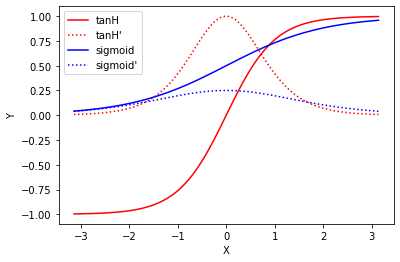

In [373]:
in_array = np.linspace(-np.pi, np.pi, 120) 

tan_h = np.tanh(in_array) 
sig = sigmoid(in_array)  
 
plt.plot(in_array, tan_h, color = 'red', label='tanH')
plt.plot(in_array, 1-tan_h**2, linestyle=':', color = 'red', label="tanH'")
plt.plot(in_array, sig, color = 'blue', label='sigmoid')
plt.plot(in_array, sig*(1-sig), linestyle=':', color = 'blue',  label="sigmoid'")
plt.xlabel("X") 
plt.ylabel("Y") 
plt.legend(loc='best')
plt.show();